In [1]:
import ner_util

In [4]:
Xtrain, Ytrain = ner_util.read_data('../data/train.tsv')
Xval, Yval = ner_util.read_data('../data/devel.tsv')

In [13]:
Xtrain[100]

In [14]:
Ytrain[100]

## 1. Adding an RNN to the sentence encoder
We added a single LSTM layer between the word embedding and linear output layer

In [111]:
import torch
from torch import nn
import sys
from torch.autograd import Variable 

class BaselineSequenceModel(nn.Module):
    
    def __init__(self, seq_labeler):
        super().__init__()                
        
        p = seq_labeler.params
             
        self.word_embedding = seq_labeler.word_voc.make_embedding_layer(finetune=p.finetune_word_emb, 
                                                                        emb_dim=p.word_emb_dim)
        
        self.LSTM = nn.LSTM(input_size=p.word_emb_dim, 
                            hidden_size=64, 
                            num_layers=1, 
                            batch_first=True, 
                            bidirectional=True)
        
        word_emb_dim = self.word_embedding.weight.shape[1]
        
        self.top_layer = nn.Linear(word_emb_dim, seq_labeler.n_labels)
        
        self.relu = nn.ReLU()
                        
    def forward(self, words):
        h0 = torch.zeros(self.LSTM.num_layers+1, words.size(0), self.LSTM.hidden_size).cuda()
        c0 = torch.zeros(self.LSTM.num_layers+1, words.size(0), self.LSTM.hidden_size).cuda()
        
        x = self.word_embedding(words)
        x, (hh, cn) = self.LSTM(x, (h0, c0))
        x = self.top_layer(x)
        return x

## Training the system

As usual, we create an object that contains all hyperparameters.

In [113]:
class NERParameters:
    random_seed = 0    
    
    device = 'cuda'
    word_emb_dim = 128
    
    finetune_word_emb = True

    n_epochs = 20
    batch_size = 32    
    learning_rate = 0.005
    weight_decay = 0

    word_dropout_prob = 0.0
        
    use_characters = False

In [115]:
ner_system = ner_util.SequenceLabeler(NERParameters(), BaselineSequenceModel)
ner_system.fit(Xtrain, Ytrain, Xval, Yval)

Epoch 1: train loss = 0.3725, val f1: 0.5186, time = 1.9831
Epoch 2: train loss = 0.1148, val f1: 0.6503, time = 1.9785
Epoch 3: train loss = 0.0506, val f1: 0.6648, time = 1.9615
Epoch 4: train loss = 0.0240, val f1: 0.6804, time = 1.9539
Epoch 5: train loss = 0.0102, val f1: 0.6877, time = 1.9680
Epoch 6: train loss = 0.0046, val f1: 0.6924, time = 1.9750
Epoch 7: train loss = 0.0018, val f1: 0.6948, time = 1.9545
Epoch 8: train loss = 0.0008, val f1: 0.6948, time = 1.9696
Epoch 9: train loss = 0.0005, val f1: 0.6962, time = 1.9734
Epoch 10: train loss = 0.0004, val f1: 0.6963, time = 1.9502
Epoch 11: train loss = 0.0003, val f1: 0.6971, time = 1.9485
Epoch 12: train loss = 0.0002, val f1: 0.6970, time = 1.9865
Epoch 13: train loss = 0.0002, val f1: 0.6965, time = 2.0010
Epoch 14: train loss = 0.0001, val f1: 0.6962, time = 1.9960
Epoch 15: train loss = 0.0001, val f1: 0.6969, time = 1.9605
Epoch 16: train loss = 0.0001, val f1: 0.6972, time = 1.9835
Epoch 17: train loss = 0.0001, va

0.6972444860469198

Text(0.5, 1.0, 'Validation F-score')

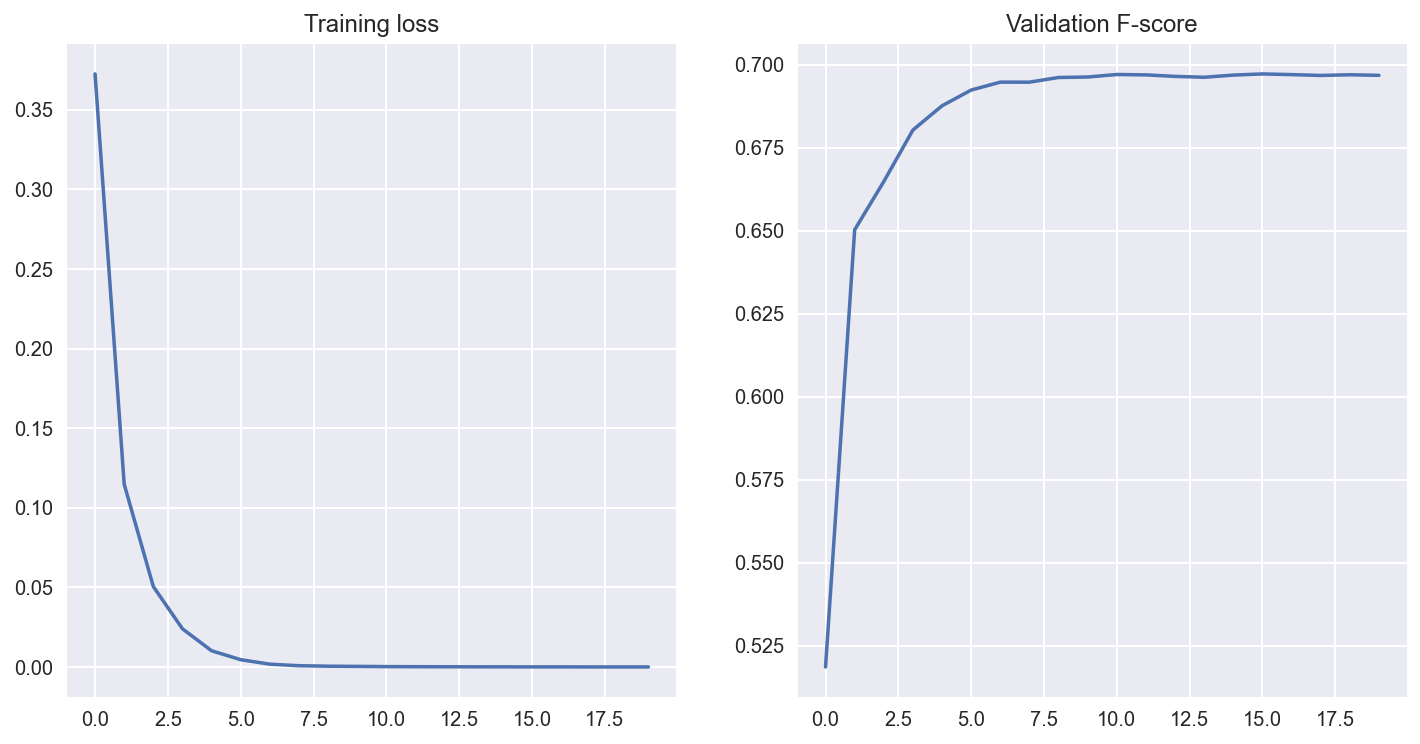

In [116]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 
plt.style.use('seaborn')

fig, ax = plt.subplots(1, 2, figsize=(2*6,1*6))
ax[0].plot(ner_system.history['train_loss']);
ax[0].set_title('Training loss')
ax[1].plot(ner_system.history['val_f1']);
ax[1].set_title('Validation F-score')

Predicting outputs:

In [117]:
tokens = 'The patient suffered from bubonic plague and COVID-19 .'.split()
ner_system.predict([tokens])

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]

In [118]:
ner_util.show_entities(ner_system, [tokens])

### Discussion:
*This dataset was published before anyone had heard of COVID-19. Assuming your system is actually able to spot this disease name (which will depend on how you implemented your solution), why is this possible if this disease is not present in the training set?*
*Look at a few examples from the validation set and see what the system does.*

It is possible because of the sentence structure. If it was able to determine **bubonic plague** is a disease, it should know that **COVID-19** is too because of the **and** cojunction. It may also pick up that acronyms are often diseases, e.g. AIDS/HIV/MD.

